In [1]:
import scipy.io
import numpy as np
import itertools
from scipy.fftpack import fft, fftfreq
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import math
from scipy import stats
import csv
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import metrics

plt.rcParams["font.family"] = "Times New Roman"

In [2]:
## import dataset
mat = scipy.io.loadmat('SSVEPDataset.mat')
data = mat['subject'][0]
number_of_subjects = len(data)
number_of_conditions = len(data[0])
number_of_samplings = len(data[0][0])
print "Data includes", number_of_subjects, "subjects :"
print "(", number_of_conditions, "conditions per subject )"
print "(", number_of_samplings, "samplings per condition )"
#print data

Data includes 12 subjects :
( 5 conditions per subject )
( 15000 samplings per condition )


In [3]:
def get_data(data, condition_id):

    #get data
    data_selected = np.zeros((number_of_subjects, number_of_samplings-number_of_filter_out_samplings))
    for i, d in enumerate(data):
        #one loop is one subject
        join_list = list(itertools.chain.from_iterable(d[condition_id-1]))

        #bandpass filter
        nyq = 0.5 * number_of_samplings_per_sec
        low = 7 / nyq
        high = 8 / nyq
        order = 2
        b, a = butter(order, [low, high], btype='band')
        f = lfilter(b, a, join_list)

        #filter out first-nine second
        data_selected[i] = f[number_of_filter_out_samplings:]

    print "Select data from condition #", condition_id
    print "Size of data is", len(data_selected), "subjects with", len(data_selected[0]), "samplings per subject."
    
    return data_selected

In [12]:
def perform_fft(data_selected, window_size):

    #FFT
    for i, d in enumerate(data_selected):
        #print "==== FFT with subjects #", i, "===="
        for index in range(0, number_of_slide_windows):
            #one loop per window
#             print "From second #", index, "to", index+window_size-1,"( sampling no.", \
#                     index*number_of_samplings_per_sec, "to", (index + window_size) * number_of_samplings_per_sec - 1, ")"

            #FFT
            fft_out = fft(d[index*number_of_samplings_per_sec : (index + window_size) * number_of_samplings_per_sec])

            freqs = fftfreq(len(fft_out)) * number_of_samplings_per_sec

            #Get maximum magnitude value from window_size freq
            if window_size == 4:
                fix_freq = 7.5
            elif window_size == 5:
                fix_freq = 7.6
            elif window_size == 6:
                fix_freq = 7.5
            elif window_size == 8:
                #still cannot find fix freq
                #peak is around 7.56-7.58
                #but after find from 7.5 to 7.8 (with scale + 0.00001), I still cannot find it
                fix_freq = 7.5
            elif window_size == 10:
                fix_freq = 7.6

            fft_out_max_list[i][index] = np.abs(fft_out)[np.where(freqs==fix_freq)]

            """
            if index == number_of_slide_windows - 1:
                #plot FFT of some specific window
                fig, ax = plt.subplots()
                ax.plot(freqs, np.abs(fft_out))
                ax.set_xlabel('Frequency in Hertz [Hz]')
                ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
                ax.set_xlim(1, 15)
                ax.set_ylim(1, 2500)
                plt.grid()
                plt.show() 
            """
            
        #z-score normalization
        fft_out_max_list[i] = stats.zscore(fft_out_max_list[i])  

        """
        plt.plot(fft_out_max_list[i], 'ro')
        plt.xlabel('Window no.')
        plt.ylabel('Max Spectrum Magnitude')
        plt.grid()
        plt.show()
        """
        
    return fft_out_max_list

In [5]:
def fit_curve(x, y, degree):
    coefs = []
    
    for i in range(number_of_subjects):
        coefs.append(np.polyfit(x[i], y[i], degree))
        
    print 'Curve fitting done!'
    return coefs   

In [6]:
def plot_curve(coef, fft_out, light_intensity, cond):
    y_pred = []
    for i, c in enumerate(coef):
        ffit = np.poly1d(c)
        ys = []
        for x in fft_out[i]:
            ys.append(ffit(x))
        
        """
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.scatter( fft_out[i], ys, s=10, c='b', marker="s", label='curve fitting')
        ax1.scatter( fft_out[i], light_intensity[i], s=10, c='r', marker="o", label='actual data')
        plt.title('Subject#' + str(i) + ', Condition#' + str(cond))
        plt.legend(loc='upper left');
        plt.show()
        """
        
        y_pred.append(ys)
        
    return y_pred

In [24]:
def plot_avg_curve(fft_out, cond, degree):
    
    avg = np.mean(fft_out, axis = 0)
    time_steps = [x for x in range(0, number_of_slide_windows)]
    yerr = np.std(fft_out, axis=0) / math.sqrt(number_of_subjects)
    
    #curve fit
    coef = np.polyfit(time_steps, avg, degree)
    ffit = np.poly1d(coef)
    ys = []
    for a in time_steps:
        ys.append(ffit(a))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(time_steps, ys, lw=2.5, color="#424949")
    
    #plot errorbar
    ax.errorbar(time_steps, avg, yerr, linestyle='None', \
                 fmt='o', markersize=2, color='r', capsize=2, lw=1)
    
    plt.xlabel('Time Steps', fontsize=12, fontweight='bold')
    plt.ylabel('Normalized SSVEP', fontsize=12, fontweight='bold')
    plt.show()

In [8]:
def get_rmse(y_true, y_pred):
    RMSEs = np.zeros(shape = (number_of_subjects,1))
    
    for i in range(number_of_subjects):
        RMSEs[i] = np.sqrt(np.sum(np.square(y_pred[i]-y_true[i]))/ len(y_true[i]))
    
    return RMSEs

In [9]:
def get_r2(y_true, y_pred):
    R2s = np.zeros(shape = (number_of_subjects,1))
    
    for i in range(number_of_subjects):
        R2s[i] = metrics.r2_score(y_true[i], y_pred[i])
    
    return R2s

In [10]:
def write_result_to_csv(results, res_type):
    print 'Start writing results from', len(results), 'conditions'
    
    dir_path = './results/'
    filename = dir_path + res_type
    
    for index, r in enumerate(results):
        csvfile1 = open(filename + '_con' + str(conditions[index]) + \
                        '_win' + str(window_sizes) + '.csv', 'wb')

        wr1 = csv.writer(csvfile1, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)

        row = ['subject_id']
        for wind in window_sizes:
            row.append('win' + str(wind))
            
        wr1.writerow(row)

        for i in range(0, number_of_subjects):
            row = [i]
            for wind_index in range(0, number_of_window_sizes):
                row.append(results[index][wind_index][i])
            wr1.writerow(row)

        csvfile1.close()
    
    print 'Finish writing:', res_type

################### window size = 5 ###################
Parameter settings: 1st window start at intensity = 105 , end at intensity = 246

Parameter setting : all = 60 seconds, used =  51 seconds
Each subjects contains 47 windows.
Select data from condition # 1
Size of data is 12 subjects with 12750 samplings per subject.
Curve fitting done!


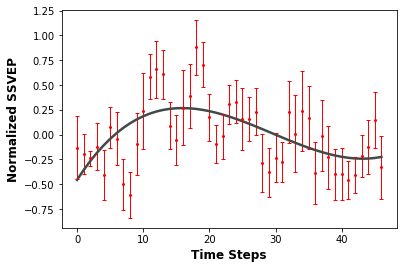


Select data from condition # 2
Size of data is 12 subjects with 12750 samplings per subject.
Curve fitting done!


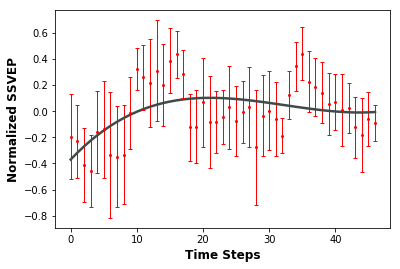


Select data from condition # 3
Size of data is 12 subjects with 12750 samplings per subject.
Curve fitting done!


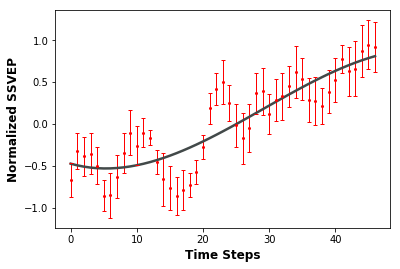


Select data from condition # 4
Size of data is 12 subjects with 12750 samplings per subject.
Curve fitting done!


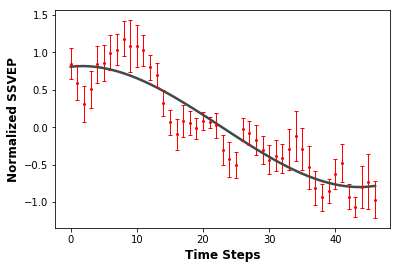


Select data from condition # 5
Size of data is 12 subjects with 12750 samplings per subject.
Curve fitting done!


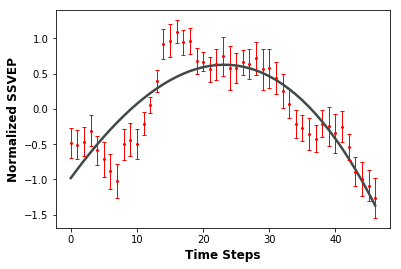

In [25]:
## get data, plot curve and get RMSE

#setting parameters
conditions = [1, 2, 3, 4, 5]
number_of_samplings_per_sec = 250
filtered_secs = 9
degree = 3
window_sizes = [5] #seconds
selected_data_start = None #default is None
selected_data_end = None #default is None

number_of_selected_conditions = len(conditions)
number_of_window_sizes = len(window_sizes)
RMSE_all = np.zeros(shape = (number_of_selected_conditions, number_of_window_sizes, number_of_subjects))
R2_all = np.zeros(shape = (number_of_selected_conditions, number_of_window_sizes, number_of_subjects))

for w, wind in enumerate(window_sizes):
    print '################### window size =', wind, '###################'
    all_secs = number_of_samplings/number_of_samplings_per_sec
    used_secs = all_secs - filtered_secs
    number_of_filter_out_samplings = number_of_samplings_per_sec * filtered_secs
    number_of_slide_windows = used_secs-wind+1
    fft_out_max_list = np.zeros((number_of_subjects, number_of_slide_windows))

    intensity_step = 3
    first_light_intensity_begin = 105
    last_light_intensity_begin = (number_of_slide_windows * intensity_step) + first_light_intensity_begin
    print "Parameter settings: 1st window start at intensity =", first_light_intensity_begin, \
            ", end at intensity =", last_light_intensity_begin
    print

    # Test/train split
    light_intensity = np.arange(first_light_intensity_begin, last_light_intensity_begin, intensity_step)
    light_intensity = np.tile(light_intensity,(number_of_subjects,1))

    print "Parameter setting : all =", all_secs, "seconds, used = ", used_secs, "seconds" 
    print "Each subjects contains", number_of_slide_windows, "windows."

    curve_coefs = []

    for i, cond in enumerate(conditions):
        data_selected = get_data(data, cond)
        fft_out = perform_fft(data_selected, wind)

        if selected_data_start != None and selected_data_end != None:
            x = [f[selected_data_start: selected_data_end] for f in fft_out]
            y_true = [l[selected_data_start: selected_data_end] for l in light_intensity]
        else:
            x = fft_out
            y_true = light_intensity
            
        curve_coefs.append(fit_curve(x, y_true, degree))
        y_pred = plot_curve(curve_coefs[i], x, y_true, cond)
        plot_avg_curve(x, cond, degree)
        
        """
        RMSE = get_rmse(y_true, y_pred)
        RMSE_all[i][w] = np.concatenate(RMSE)
        R2 = get_r2(y_true, y_pred)
        R2_all[i][w] = np.concatenate(R2)
        """
        
        RMSE = get_rmse(y_true, y_pred)
        RMSE_all[i][w] = np.concatenate(RMSE)
        R2 = get_r2(y_true, y_pred)
        R2_all[i][w] = np.concatenate(R2)
        
        print '======================================='
        print

In [ ]:
print 'got results from', RMSE_all.shape[0], 'conditions, ', RMSE_all.shape[1], \
        'window sizes, ', RMSE_all.shape[2], 'subjects'
write_result_to_csv(RMSE_all, 'rmse')
write_result_to_csv(R2_all, 'r2')